<a href="https://colab.research.google.com/github/FacuRoffet99/PDI/blob/main/practico_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico 5 - Procesamiento Digital de Imágenes

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import convolve2d

# %matplotlib inline

In [2]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

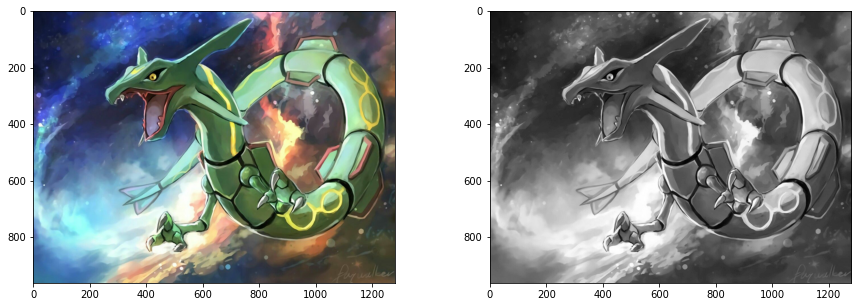

In [3]:
url = 'https://i.pinimg.com/originals/41/bd/71/41bd71198330df56ff05c64793e10d1f.jpg'
img_rgb = imageio.imread(url)/255
img = rgb2yiq(img_rgb)[:,:,0]

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(img, 'gray')

## 1. Filtros convolucionales

Para cada uno de los siguientes incisos implementar una función que devuelva el kernel en función de los parámetros especificados. Luego convolucionar la imagen con el kernel y utilizar la función plot_images_and_kernel() para graficar el resultado.



In [4]:
from matplotlib import cm

def plot_kernel(data, ax=None):
    rows, cols = data.shape
    y, x = np.meshgrid(np.arange(rows),np.arange(cols),indexing='ij')
    if ax == None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    _min, _max = (np.min(data), np.max(data))
    ax.plot_surface(x, y, data.T, cmap=cm.jet, vmin=_min, vmax=_max)

def plot_images_and_kernel(img, img_filt, kernel):
    fig = plt.figure(figsize=(17,5))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img, 'gray')
    ax1.title.set_text('Input image')
    ax2 = fig.add_subplot(132)
    ax2.imshow(img_filt, 'gray')
    ax2.title.set_text('Filtered image')
    ax3 = fig.add_subplot(133, projection='3d')
    plot_kernel(kernel, ax=ax3)
    ax3.title.set_text('Kernel')
    plt.show()

### 1.1. Implementar los siguientes filtros simétricos (invariantes a la rotación de 90°)

Pasabajos: Los kernels tendrán que ser del tamaño especificado por el usuario. Todos son de NxN donde N es impar.

1. Box (cuadrado) -> params: N
2. Circle (circular) -> params: N
3. Bartlett -> params: N
4. Gaussian -> params: N, std

Pasaaltos:

5. Laplace (4 y 8 vecinos) -> params: neighbors (entero que vale 4 u 8)
6. Pasaaltos a partir de un pasabajos: PA = Id - PB -> params: los mismos que el pasabajos elegido

Pasabanda:

7. Difference of Gaussian (DoG) -> params: N, std1, std2

Otros:

8. Mejora de contraste (combinación del filtro identidad más "un poco" de pasaaltos) -> params: los del pasaaltos y la constante de proporción de pasaaltos sumado



In [5]:
from scipy.stats import norm

# 1
def box_filter(N):
  return np.ones((N,N))/(N**2)

# 2
def circle_filter(N):
  # Centro de la imagen
  center = (int(N/2), int(N/2))
  # Radio del círculo
  radius = int(N/2)
  # Calcular distancias
  Y, X = np.ogrid[:N, :N]
  dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
  # Filtrar lo que no está dentro del radio
  mask = dist_from_center <= radius
  return mask/mask.sum()

# 3
def bartlett_filter(N):
  # Máximo número de la secuencia
  max = (N+1)/2
  # Arreglos en orden ascendente y descendente
  asc = np.arange(1,max)
  desc = np.arange(max,0,-1)
  # Junto los arreglos y obtengo la secuencia
  sec = np.expand_dims(np.append(asc,desc),1)
  # Producto exterior de la secuencia
  mat = np.matmul(sec,sec.T)
  return mat/mat.sum()

# 4
def gaussian_filter(N,std=1):
  # Creo el eje
  max = (N-1)/2
  axis = np.arange(-max,max+1)
  # Obtengo la secuencia
  sec = np.expand_dims(norm.pdf(axis,scale=std),1)
  # Producto exterior de la secuencia
  mat = np.matmul(sec,sec.T)
  return mat/mat.sum()

In [ ]:
# 5
def laplace_filter(neighbors=4):
  if neighbors==4:
    return np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
  if neighbors==8:
    return np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])    

# 6
def highpass_filter(PB):
  Id = np.eye(PB.shape[0])/PB.shape[0]
  return Id-PB

In [ ]:
# 7
def gaussian_difference_filter(N1,N2,std1=1,std2=1):
  k1 = gaussian_filter(N1,std1)
  k2 = gaussian_filter(N2,std2)
  if N1<N2:
    add = int((N2-N1)/2)
    k1 = np.pad(k1,(add,add))
  else:
    add = int((N1-N2)/2)
    k2 = np.pad(k2,(add,add))    
  return k1-k2

In [ ]:
# 8
def enhancement_filter(PA,const):
  I = np.zeros_like(PA)
  mid_index = int((I.shape[0]-1)/2)
  I[mid_index,mid_index] = 1
  return I + PA*const

#### Resultados

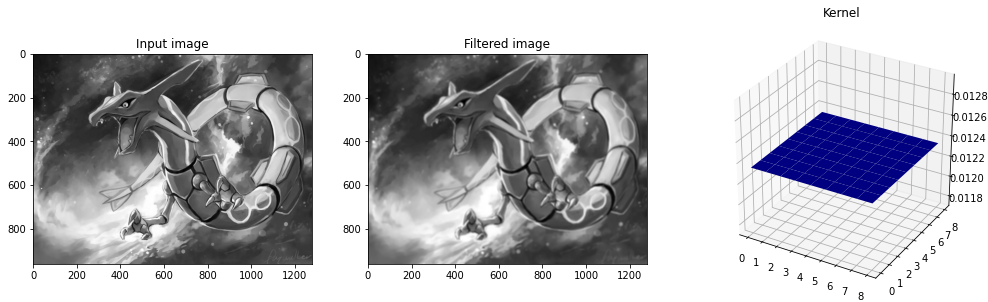

In [ ]:
# 1
kernel = box_filter(9)
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, img_filt, kernel)

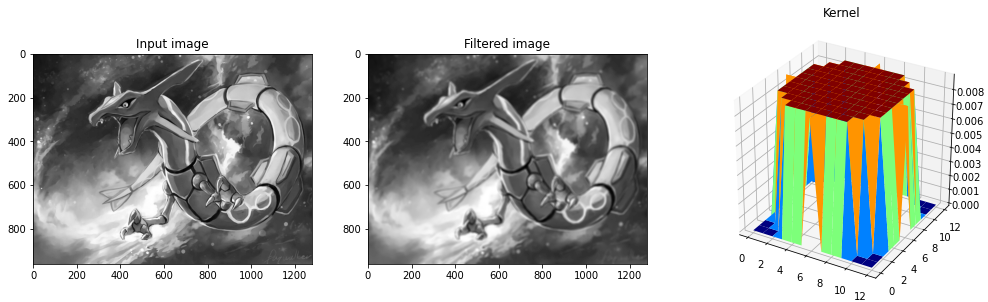

In [8]:
# 2
kernel = circle_filter(13)
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, img_filt, kernel)

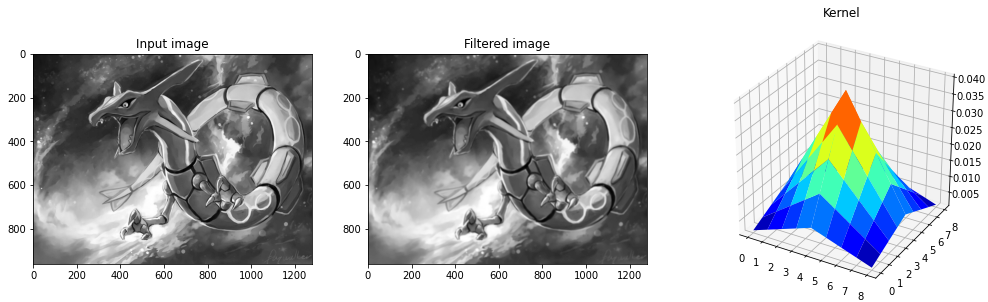

In [ ]:
# 3
kernel = bartlett_filter(9)
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, img_filt, kernel)

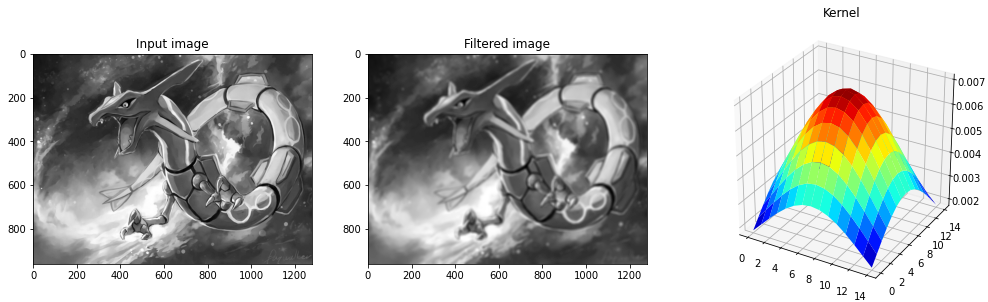

In [ ]:
# 4
kernel = gaussian_filter(15,6)
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, img_filt, kernel)

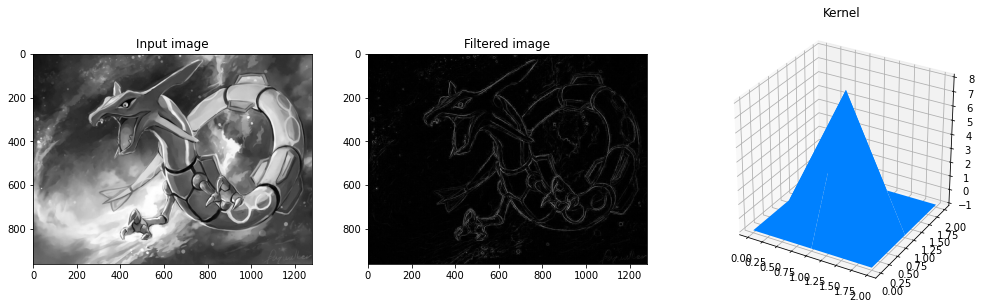

In [ ]:
# 5
kernel = laplace_filter(8)
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, np.clip(img_filt,0,1), kernel)

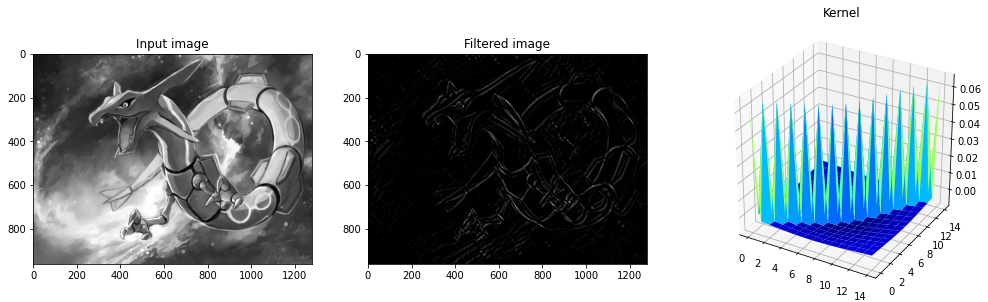

In [ ]:
# 6
kernel = highpass_filter(gaussian_filter(15,5))
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, np.clip(img_filt,0,1), kernel)

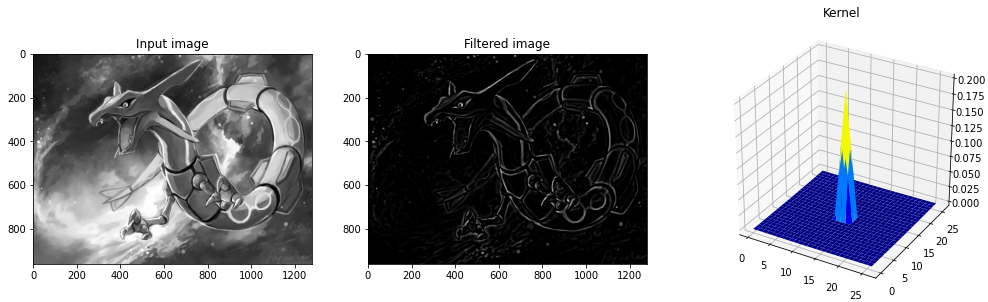

In [ ]:
# 7
kernel = gaussian_difference_filter(3,27,std1=1,std2=9)
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, np.clip(img_filt,0,1), kernel)

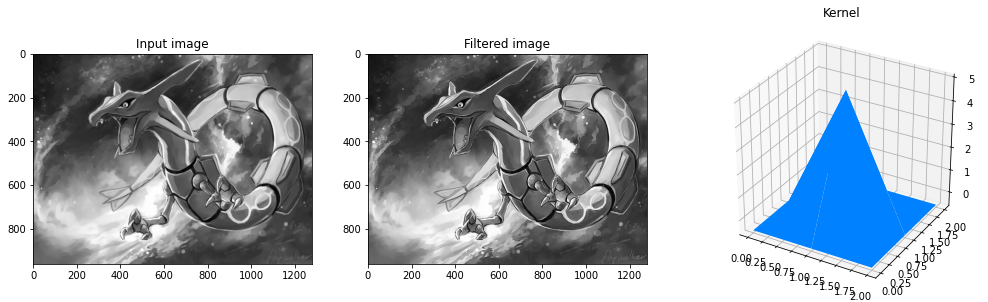

In [ ]:
# 8
kernel = enhancement_filter(laplace_filter(8),0.5)
img_filt = convolve2d(img, kernel, 'same', 'symm')
plot_images_and_kernel(img, np.clip(img_filt,0,1), kernel)

### 1.2. Implementar los siguientes filtros direccionales (asimétricos)

9. Sobel 3x3 -> Calcular valor absoluto de gradientes Gx y Gy y también en módulo y fase. Para graficar la fase, normalizar al rango [0,1] y utilizar un mapa de colores que no sea escala de grises.



In [ ]:
def apply_sobel(img):
  # Kernels
  Gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  Gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])  
  # Convoluciones
  grad_x = convolve2d(img, Gx, 'same', 'symm')
  grad_y = convolve2d(img, Gy, 'same', 'symm')
  # Obtener módulo y fase
  mod = np.sqrt(grad_x**2 + grad_y**2)
  pha = (np.arctan2(grad_y,grad_x) + np.pi) / (2*np.pi) 
  return mod, pha 

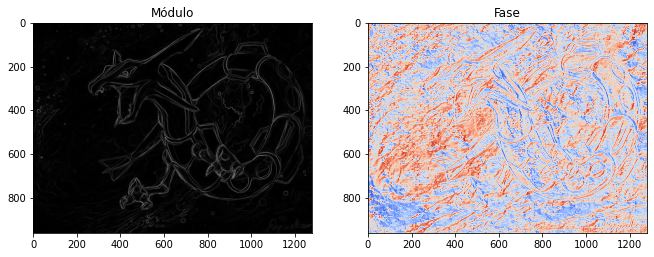

In [ ]:
mod, pha = apply_sobel(img)

fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(131)
ax1.imshow(mod, 'gray')
ax1.title.set_text('Módulo')
ax2 = fig.add_subplot(132)
ax2.imshow(pha, 'coolwarm')
ax2.title.set_text('Fase')
plt.show()

### 1.3. Implementar un detector de bordes a partir del filtro de Sobel

Aplicar un umbral al módulo del filtro de Sobel para obtener una imagen binaria con 1s en los bordes y 0s en el resto



In [ ]:
def sobel_detector(img, thresh=0.5):
  # Obtener módulo del gradiente
  mod, _ = apply_sobel(img)
  # Aplicar umbral y binarizar
  mod[mod>=thresh] = 1
  mod[mod<thresh] = 0
  return mod

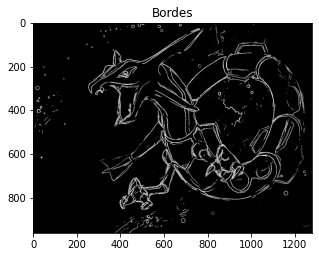

In [ ]:
img_filt = sobel_detector(img, 0.6)

fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(131)
ax1.imshow(img_filt, 'gray')
ax1.title.set_text('Bordes')
plt.show()

### 1.4. Escribir una breve descripción sobre cómo funciona el detector de bordes de Canny

El detector de bordes de Canny se divide en 5 pasos:
1.   Filtrado: se aplica un filtro pasabajos gaussiano para eliminar el ruido de la imagen (implementado en la función gaussian_filter(N,std) de este TP).
2.   Gradiente: se obtiene el módulo y la fase del gradiente de la imagen al aplicar el filtro de Sobel (implementado en la función apply_sobel(img) de este TP). 
3.   Supresión no máxima: se le asigna el valor 0 a cada píxel cuya magnitud de gradiente es más pequeña que al menos dos de sus vecinos en la dirección del ángulo del gradiente. El resto de los píxeles mantienen sus valores originales. 
4.   Doble umbral: se clasifica a cada uno de los píxeles para poder eliminar a los que fueron causados por ruido, a partir de la elección de un umbral máximo y uno mínimo. Si un píxel tiene un valor de gradiente mayor que el del umbral máximo, se lo marca como un borde fuerte. Si tiene un valor de gradiente menor al umbral máximo pero mayor al umbral mínimo, se lo clasifica como un borde débil. Los demás píxeles (cuyos gradientes son menores al umbral mínimo) son eliminados.
5.   Histéresis: los bordes fuertes se mantienen, pero los bordes débiles se filtran al comprobar si son conexos o no. Se define que un píxel correspondiente a un borde débil es conexo cuando al menos uno de sus 8 píxeles vecinos fue clasificado como borde fuerte. Por lo tanto, los bordes débiles conexos se mantienen, mientras que los no conexos se eliminan.










